In [1]:
!pip install -q onnxruntime
!pip install SimpleITK 
!pip install self-attention-cv==1.2.3
!pip install nibabel 

  Using cached simpleitk-2.5.2-cp311-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (7.2 kB)
Using cached simpleitk-2.5.2-cp311-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (52.6 MB)
  Using cached self_attention_cv-1.2.3-py3-none-any.whl.metadata (7.1 kB)
  Using cached einops-0.8.1-py3-none-any.whl.metadata (13 kB)
Using cached self_attention_cv-1.2.3-py3-none-any.whl (42 kB)
Using cached einops-0.8.1-py3-none-any.whl (64 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [self-attention-cv]
  Using cached nibabel-5.3.2-py3-none-any.whl.metadata (9.1 kB)
Using cached nibabel-5.3.2-py3-none-any.whl (3.3 MB)


In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import onnxruntime" || pip install -q onnxruntime

In [9]:
import os
from glob import glob
import torch
import numpy as np
from monai.data import decollate_batch, DataLoader, Dataset, CacheDataset
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    RandFlipd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    RandShiftIntensityd,
    RandAffined,
    AsDiscreted,
    SpatialPadd,
    Invertd,
    Activationsd,
    SaveImaged,
    Activations,
    ToTensord
)

from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd,
    ScaleIntensityRanged, CropForegroundd, RandCropByPosNegLabeld,
    RandFlipd, RandRotate90d, EnsureTyped, Lambdad
)

from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.utils import set_determinism

In [ ]:
from monai.transforms import MapLabelValued, Compose, LoadImaged, AddChanneld

train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),             
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(
        keys=["image", "label"],
        pixdim=(1.5, 1.5, 2.0),
        mode=("bilinear", "nearest"),
    ),

    
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-150, a_max=250,
        b_min=0.0, b_max=1.0,
        clip=True,
    ),

    # Remove large air background
    CropForegroundd(keys=["image", "label"], source_key="image"),

    

    RandCropByPosNegLabeld(
        keys=["image", "label"],
        label_key="label",
        spatial_size=(96, 96, 96),
        pos=4,                   
        neg=1,
        num_samples=5,
        image_key="image",
        image_threshold=0,
        allow_smaller = True
    ),

    # Spatial augs
    RandFlipd(keys=["image", "label"], prob=0.3, spatial_axis=[0]),
    RandFlipd(keys=["image", "label"], prob=0.3, spatial_axis=[1]),
    RandFlipd(keys=["image", "label"], prob=0.3, spatial_axis=[2]),
    RandRotate90d(keys=["image", "label"], prob=0.3, max_k=3),
    RandShiftIntensityd(keys = ["image"], offsets = 0.10, prob = 0.50),
    RandAffined(
        keys=["image", "label"],
        mode=("bilinear", "nearest"),
        prob = 0.1,
        spatial_size = (96, 96, 96),
        rotate_range = ( 0, 0, np.pi/15),
        scale_range = (0.1, 0.1, 0.1)
    ),
    # Torch tensors on output
    ToTensord(keys=["image", "label"]),
])


In [ ]:
spacing = (1.5, 1.5, 2.0)
roi_size = (96, 96, 96)
val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),             
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(
        keys=["image", "label"],
        pixdim=(1.5, 1.5, 2.0),
        mode=("bilinear", "nearest"),
    ),

   
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-150, a_max=250,
        b_min=0.0, b_max=1.0,
        clip=True,
    ),
    
    
    CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
    SpatialPadd(keys=["image", "label"], spatial_size=(96, 96, 96)),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    ToTensord(keys=["image", "label"]),
    EnsureTyped(keys=["image", "label"])
])


In [ ]:
# Prediction: logits -> softmax -> argmax, invert to original, save
val_save_dir = 'data/val_results'
post_pred_transforms = Compose([
    EnsureTyped(keys=["pred"]),                         # make MetaTensor
    Activationsd(keys=["pred"], softmax=True),
    AsDiscreted(keys=["pred"], argmax=True),            # [B,1,D,H,W]
    Invertd(
        keys=["pred"],
        transform=val_transforms,
        orig_keys=["image"],
        meta_keys=["pred_meta_dict"],
        orig_meta_keys=["image_meta_dict"],
        meta_key_postfix="meta_dict",
        nearest_interp=True,                            # masks => nearest
        to_tensor=True,
    ),
    SaveImaged(
        keys=["pred"], meta_keys=["pred_meta_dict"],
        output_dir=val_save_dir, output_postfix="pred",
        output_ext=".nii.gz", resample=False,
        dtype=np.uint8, separate_folder=False, print_log=False,
    ),
])

post_label_img_transforms = Compose([
    Invertd(
        keys=["label"],
        transform=val_transforms,
        orig_keys=["image"],
        meta_keys=["label_meta_dict"],
        orig_meta_keys=["image_meta_dict"],
        meta_key_postfix="meta_dict",
        nearest_interp=True, to_tensor=True,
    ),
    SaveImaged(
        keys=["label"], meta_keys=["label_meta_dict"],
        output_dir=val_save_dir, output_postfix="label",
        output_ext=".nii.gz", resample=False,
        dtype=np.uint8, separate_folder=False, print_log=False,
    ),
    Invertd(
        keys=["image"],
        transform=val_transforms,
        orig_keys=["image"],
        meta_keys=["image_meta_dict"],
        orig_meta_keys=["image_meta_dict"],
        meta_key_postfix="meta_dict",
        nearest_interp=False, to_tensor=True,
    ),
    SaveImaged(
        keys=["image"], meta_keys=["image_meta_dict"],
        output_dir=val_save_dir, output_postfix="image",
        output_ext=".nii.gz", resample=False,
        dtype=np.float32, separate_folder=False, print_log=False,
    ),
])

In [7]:
def create_data_dicts(image_dir, label_dir):
   """Create paired data dictionaries for training"""
   # Get all image files
   image_files = sorted(glob.glob(os.path.join(image_dir, "*.nii.gz*")))
   data_dicts = []
   samples_with_tumor = 0
   samples_without_tumor = 0
   for image_path in image_files:
       # Get corresponding label path
       filename = os.path.basename(image_path)
       label_path = os.path.join(label_dir, filename)
       if os.path.exists(label_path):
           # Check if label contains tumor (non-zero values)
           label_img = nib.load(label_path)
           label_data = label_img.get_fdata()
           has_tumor = np.any(label_data > 0)
           data_dict = {
               "image": image_path,
               "label": label_path,
               "has_tumor": has_tumor,
               "sample_id": filename.split('.')[0]  # e.g., "liver_0"
           }
           data_dicts.append(data_dict)
           if has_tumor:
               samples_with_tumor += 1
           else:
               samples_without_tumor += 1
   print(f"Dataset created:")
   print(f"Total samples: {len(data_dicts)}")
   print(f"Samples with tumor: {samples_with_tumor}")
   print(f"Samples without tumor: {samples_without_tumor}")
   return data_dicts
# Create train/validation split
def split_data(data_dicts, train_ratio=0.8):
   """Split data maintaining tumor/non-tumor balance"""
   tumor_samples = [d for d in data_dicts if d["has_tumor"]]
   no_tumor_samples = [d for d in data_dicts if not d["has_tumor"]]
   # Split each group
   np.random.shuffle(tumor_samples)
   np.random.shuffle(no_tumor_samples)
   n_train_tumor = int(len(tumor_samples) * train_ratio)
   n_train_no_tumor = int(len(no_tumor_samples) * train_ratio)
   train_data = tumor_samples[:n_train_tumor] + no_tumor_samples[:n_train_no_tumor]
   val_data = tumor_samples[n_train_tumor:] + no_tumor_samples[n_train_no_tumor:]
   np.random.shuffle(train_data)
   np.random.shuffle(val_data)
   print(f"Training samples: {len(train_data)}")
   print(f"Validation samples: {len(val_data)}")
   return train_data, val_data

In [40]:
import glob 
import nibabel as nib
data_dir = "data"
image_dir = os.path.join(data_dir, "images_liver_2")
label_dir = os.path.join(data_dir, "labels_tumor_cropped")
data_dicts = create_data_dicts(image_dir, label_dir)
train_data, val_data = split_data(data_dicts, train_ratio=0.8)

Dataset created:
Total samples: 123
Samples with tumor: 110
Samples without tumor: 13
Training samples: 98
Validation samples: 25


In [41]:
train_ds = CacheDataset(data=train_data, transform=train_transforms, cache_rate = 1, num_workers = 4)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4, pin_memory = True)

val_ds = CacheDataset(data=val_data, transform=val_transforms,  cache_rate = 1, num_workers = 2)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s]


In [42]:
import torch
from monai.networks.nets import UNet
from monai.networks.layers import Norm

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

# Model parameters
in_channels = 1
out_channels = 2 # background, tumor
spatial_dims = 3
channels = (8, 16, 32, 64)
strides = (2, 2, 2)
num_res_units = 1

# Create the UNet model
model = UNet(
    spatial_dims=spatial_dims,
    in_channels=in_channels,
    out_channels=out_channels,
    channels=channels,
    strides=strides,
    num_res_units=num_res_units,
    dropout = 0.1
).to(device)

print(f"Model created and moved to {device}.")

Model created and moved to cuda.


In [ ]:


from torch.optim import AdamW
from monai.losses import DiceCELoss, DiceFocalLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau


loss_function = DiceFocalLoss(to_onehot_y=True, softmax=True, gamma=4.0,  lambda_dice=1.0 ,lambda_focal=3.0,reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience=15, factor=0.5, min_lr=1e-6)
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)

post_pred  = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])


In [ ]:
from monai.metrics import ConfusionMatrixMetric
def save_validation_predictions(model, val_loader, post_pred_transforms, post_label_img_transforms, 
                               val_save_dir, roi_size, device):
    model.eval()
    with torch.no_grad():
        for batch_data in val_loader:
            img = batch_data["image"].to(device)
            
            # Sliding window inference
            with autocast():
                logits = sliding_window_inference(
                    img, roi_size=roi_size, sw_batch_size=2,
                    predictor=model, overlap=0.5, mode="gaussian"
                )
            
            # Prepare batch dict for inversion & saving
            save_batch = {
                "image": batch_data["image"],
                "label": batch_data["label"],
                "pred": logits.cpu(),
                "image_meta_dict": batch_data["image_meta_dict"],
                "pred_meta_dict": copy.deepcopy(batch_data["image_meta_dict"]),
            }
             
            for data_i in decollate_batch(save_batch):
                data_i = post_pred_transforms(data_i)

In [60]:
def validate_epoch(model, val_loader, loss_function, roi_size, device):
    """
    Run validation for one epoch and return metrics
    """
    confusion_matrix = ConfusionMatrixMetric(include_background=False, metric_name=["precision", "recall"])
    model.eval()
    epoch_val_losses = []
    dices = []
    precisions = []
    recalls = []
    
    with torch.no_grad():
        for batch_data in val_loader:
            img = batch_data["image"].to(device)
            lbl = batch_data["label"].to(device)
            
            # Sliding window inference with autocast
            with autocast():
                logits = sliding_window_inference(
                    img, roi_size=roi_size, sw_batch_size=2,
                    predictor=model, overlap=0.5, mode="gaussian"
                )
            
            # Calculate validation loss
            val_loss = loss_function(logits, lbl)
            epoch_val_losses.append(val_loss.item())
            
            # Calculate DICE metric
            dice_predictions = torch.argmax(torch.softmax(logits, dim=1), dim=1, keepdim=True)
            dice_metric.reset()
            dice_metric(y_pred=dice_predictions, y=lbl)
            dices.append(dice_metric.aggregate().item())

            confusion_matrix.reset()
            confusion_matrix(y_pred=dice_predictions, y =lbl)
            precision_recall = confusion_matrix.aggregate()

            precision = precision_recall[0].item() if not torch.isnan(precision_recall[0]) else 0.0 
            recall = precision_recall[1].item() if not torch.isnan(precision_recall[1]) else 0.0

            precisions.append(precision)
            recalls.append(recall)
    
    return np.mean(epoch_val_losses), np.mean(dices), np.mean(precisions), np.mean(recalls)

In [61]:
def clear_previous_predictions(val_save_dir):
    patterns = ["*pred.nii.gz", "*label.nii.gz", "*image.nii.gz", "*gt1_pred2.nii.gz"]
    for pattern in patterns:
        for file in glob.glob(os.path.join(val_save_dir, pattern)):
            try:
                os.remove(file)
            except:
                pass

In [ ]:

def train_multi_sample_tumor_segmentation(
    model, optimizer, loss_function, train_loader, val_loader, 
    post_pred_transforms, val_save_dir, scheduler, 
    roi_size=(96, 96, 96), 
    num_epochs=100, patience=15, lr_patience=10, lr_factor=0.5
):
    # Setup
    os.makedirs(val_save_dir, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Tracking variables
    metrics = { 
        'train_losses' : [],
        'val_losses' : [],
        'val_dice_scores' : [],
        'precisions': [],
        'recalls': [],
        'learning_rates' : []}
   
    best_dice = 0.0
    best_val_loss = float('inf')
    patience_counter = 0

    
    print("="*60)
    print(" Starting enhanced training with validation saving...")
    print("="*60)
    
    for epoch in range(num_epochs):
        # =============== TRAINING PHASE ===============
        model.train()
        epoch_train_losses = []
        
        for batch_data in train_loader:
            inputs = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_train_losses.append(loss.item())
        
        avg_train_loss = np.mean(epoch_train_losses)
        metrics['train_losses'].append(avg_train_loss)
        
        # =============== VALIDATION PHASE ===============
        avg_val_loss, avg_dice_score, avg_precision, avg_recall = validate_epoch(model, val_loader, loss_function, roi_size, device)
        
        # =============== CONDITIONAL PREDICTION SAVING ===============
        is_best = avg_dice_score > best_dice or avg_val_loss < best_val_loss
        
        if is_best:
            print(f" Epoch {epoch}  (DICE: {avg_dice_score:.4f}, Loss: {avg_val_loss:.4f}), (Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}). Saving preds")
            
            
            clear_previous_predictions(val_save_dir)
            save_validation_predictions(model, val_loader, post_pred_transforms, 
                                      post_label_img_transforms, val_save_dir, roi_size, device)
            
            
            if avg_dice_score > best_dice:
                best_dice = avg_dice_score
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                
            patience_counter = 0
        else:
            patience_counter += 1

            
        metrics['val_losses'].append(avg_val_loss)
        metrics['val_dice_scores'].append(avg_dice_score)
        metrics['learning_rates'].append(optimizer.param_groups[0]['lr'])
        metrics['precisions'].append(avg_precision)
        metrics['recalls'].append(avg_recall)
        
        # =============== LEARNING RATE & EARLY STOPPING ===============
        scheduler.step(avg_dice_score)
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch} (patience: {patience})")
            break
        
        # Progress reporting
        if epoch % 10 == 0:
            f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0 
            print(f"Epoch {epoch:3d}/{num_epochs}: "
                  f"Train={avg_train_loss:.4f}, Val={avg_val_loss:.4f}, "
                  f"DICE={avg_dice_score:.4f}, LR={optimizer.param_groups[0]['lr']:.2e}, "
                  f"F1 Score ={f1_score: .4f}, " 
                  f"AVG_Recall={avg_recall : .4f}, "
                  f"AVG_Precision={avg_precision}, "
                  f"Patience={patience_counter}/{patience}")
    
    # =============== FINAL SAVING & REPORTING ===============
    final_model_path = os.path.join(val_save_dir, f'final_model_epoch_{epoch}.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'final_dice': metrics['val_dice_scores'][-1],
        'best_dice': best_dice,
        'best_val_loss': best_val_loss,
        **metrics
    }, final_model_path)
    
    print("="*60)
    print(f" Training completed!")
    print(f"Final model: {final_model_path}")
    print(f"Best DICE: {best_dice:.6f}")
    print(f"Best val loss: {best_val_loss:.6f}")
    print(f"Final Recall: {metrics['recalls'][-1]}")
    print(f"Final Precision: {metrics['precisions'][-1]}")
    print(f"Predictions saved in: {val_save_dir}")
    
    return model, *metrics.values()




In [63]:
from torch.cuda.amp import autocast
import copy
import warnings 
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

model, train_losses, val_losses, val_dice_scores, precisions, recalls, lrs = train_multi_sample_tumor_segmentation(
    model = model,
    optimizer = optimizer,
    loss_function=loss_function,
    train_loader=train_loader,
    val_loader=val_loader,
    post_pred_transforms=post_pred_transforms,
    # post_label_img_transforms=post_label_img_transforms,
    val_save_dir=val_save_dir,
    scheduler=scheduler,
    roi_size=(96, 96, 96),
    num_epochs=1000,
    patience=50


)

 Starting enhanced training with validation saving...
 Epoch 0  (DICE: 0.3536, Loss: 0.3946), (Precision: 0.6256, Recall: 0.2831). Saving preds
Epoch   0/1000: Train=0.4117, Val=0.3946, DICE=0.3536, LR=1.00e-03, F1 Score = 0.3898, AVG_Recall= 0.2831, AVG_Precision=0.6256342053413391, Patience=0/50
 Epoch 1  (DICE: 0.3840, Loss: 0.3689), (Precision: 0.5866, Recall: 0.3181). Saving preds
 Epoch 3  (DICE: 0.3930, Loss: 0.3617), (Precision: 0.6527, Recall: 0.3295). Saving preds
 Epoch 4  (DICE: 0.4104, Loss: 0.3586), (Precision: 0.6658, Recall: 0.3417). Saving preds
 Epoch 5  (DICE: 0.4518, Loss: 0.3322), (Precision: 0.5687, Recall: 0.4091). Saving preds
 Epoch 8  (DICE: 0.4689, Loss: 0.3286), (Precision: 0.6076, Recall: 0.4788). Saving preds
 Epoch 9  (DICE: 0.4649, Loss: 0.3278), (Precision: 0.6532, Recall: 0.4118). Saving preds
Epoch  10/1000: Train=0.3733, Val=0.3413, DICE=0.4300, LR=1.00e-03, F1 Score = 0.4643, AVG_Recall= 0.4515, AVG_Precision=0.4778521502017975, Patience=1/50
 Epoch

In [64]:
def plot_training_curves(train_losses, val_losses, val_dice_scores, precisions, recalls, learning_rates, output_dir):
    """Generate and save comprehensive training curves with Precision/Recall"""
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    
    # Training curves data
    curves_data = [
        (axes[0,0], [train_losses, val_losses], ['Training Loss', 'Validation Loss'], 
         ['blue', 'red'], 'Loss', 'Training and Validation Loss'),
        (axes[0,1], [val_dice_scores], ['Validation DICE'], 
         ['green'], 'DICE Score', 'Validation DICE Score'),
        (axes[0,2], [precisions, recalls], ['Precision', 'Recall'], 
         ['purple', 'orange'], 'Score', 'Precision and Recall'),
        (axes[1,0], [learning_rates], ['Learning Rate'], 
         ['darkorange'], 'Learning Rate', 'Learning Rate Schedule'),
    ]
    
    # Plot individual curves
    for ax, data_list, labels, colors, ylabel, title in curves_data:
        for data, label, color in zip(data_list, labels, colors):
            ax.plot(data, label=label, color=color)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.legend()
        ax.grid(True)
        if 'Learning Rate' in title:
            ax.set_yscale('log')
    
    # Combined metrics plot
    ax_combined = axes[1,1]
    ax_twin = ax_combined.twinx()
    ax_combined.plot(val_losses, label='Val Loss', color='red', alpha=0.7)
    ax_twin.plot(val_dice_scores, label='Val DICE', color='green', alpha=0.7)
    ax_combined.set_xlabel('Epoch')
    ax_combined.set_ylabel('Validation Loss', color='red')
    ax_twin.set_ylabel('DICE Score', color='green')
    ax_combined.set_title('Combined Validation Metrics')
    ax_combined.grid(True)
    
    # F1 Score calculation and plot
    f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
    axes[1,2].plot(f1_scores, label='F1 Score', color='cyan')
    axes[1,2].set_xlabel('Epoch')
    axes[1,2].set_ylabel('F1 Score')
    axes[1,2].set_title('F1 Score (2*P*R/(P+R))')
    axes[1,2].legend()
    axes[1,2].grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_curves.png'), dpi=150, bbox_inches='tight')
    plt.show()


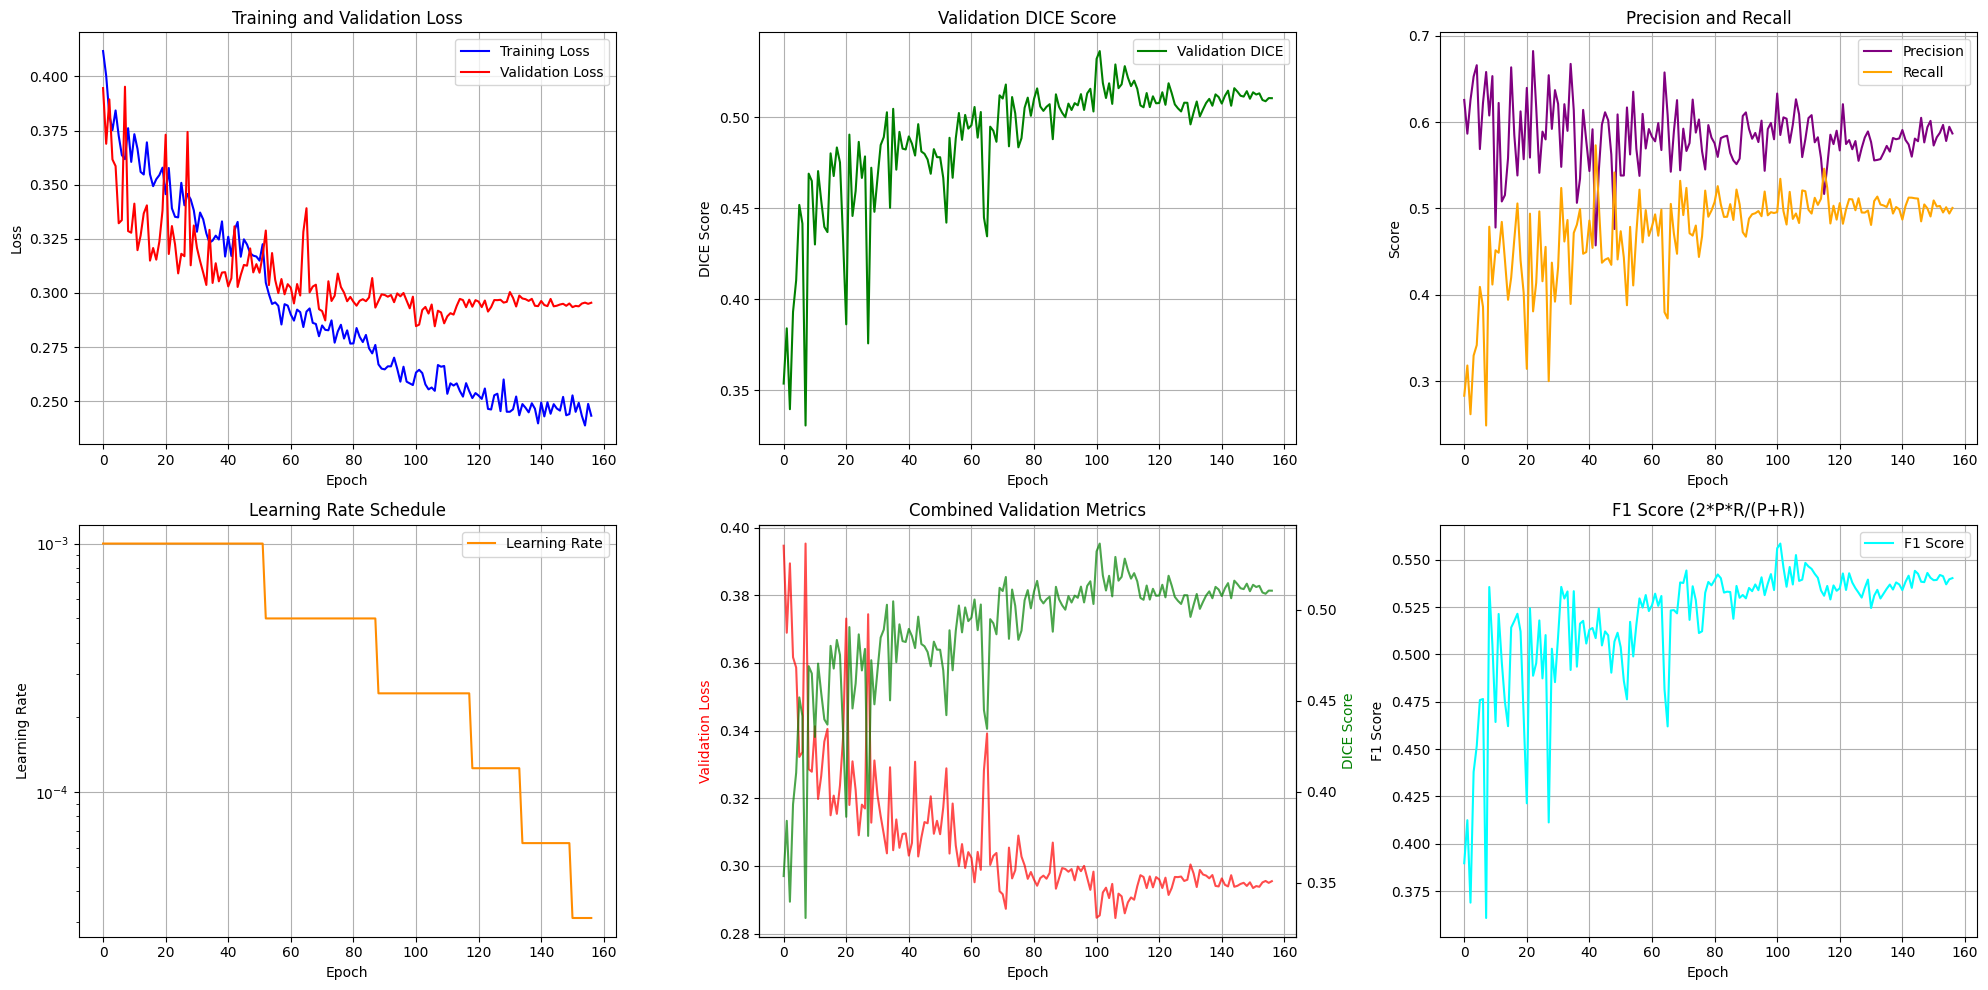

In [65]:
plot_training_curves(train_losses, val_losses, val_dice_scores, precisions, recalls, lrs, val_save_dir)